## Preparation

### Library

In [33]:
import pandas as pd
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, cross_validate
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, accuracy_score, precision_score, recall_score, f1_score, average_precision_score, ConfusionMatrixDisplay, make_scorer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer, SimpleImputer
from sklearn.linear_model import BayesianRidge
from sklearn.feature_selection import RFECV
import lightgbm as lgb
from lightgbm import LGBMClassifier
import xgboost as xgb
from xgboost import XGBClassifier
from collections import Counter
from imblearn.over_sampling import ADASYN
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.neighbors import NearestNeighbors
from sklearn.decomposition import PCA
from kneed import KneeLocator

warnings.filterwarnings("ignore")
pd.options.display.max_columns = None
pd.options.display.max_rows = None
pd.set_option('display.float_format', '{:,.2f}'.format)

### Helper

In [34]:
def cek_null(df_data):
  nan_counts = df_data.isnull().sum()
  nan_proportions = (nan_counts / len(df_data)) * 100

  nan_info = pd.DataFrame({
      'NaN_Count': nan_counts,
      'NaN_Proportion': nan_proportions
  })

  return nan_info.sort_values(by='NaN_Count', ascending=False)

def count_unique_values(df_data):
  unique_counts = []
  for col in df_data.columns:
    unique_counts.append({'Column_Name': col, 'Unique_Value_Count': df_data[col].nunique()})
  return pd.DataFrame(unique_counts)

def heatmap_null(df,att_name):
  plt.figure(figsize=(10, 6))
  sns.heatmap(df[[att_name]].isnull(), cbar=False, cmap='viridis')
  plt.title(f'Heatmap of Null Values in {att_name}')
  plt.show()

def null_proportion(df, att_name):
    # Hitung proporsi null dan non-null berdasarkan loan_status
    null_by_loan_status = df.groupby('loan_status')[att_name].apply(lambda x: x.isnull().sum() / len(x) * 100)
    non_null_by_loan_status = df.groupby('loan_status')[att_name].apply(lambda x: x.notnull().sum() / len(x) * 100)

    # Gabungkan data untuk plotting
    plot_data = pd.DataFrame({
        'Null Proportion': null_by_loan_status,
        'Non-Null Proportion': non_null_by_loan_status
    })

    plot_data = plot_data.stack().reset_index()
    plot_data.columns = ['Loan Status', 'Type', 'Proportion']

    # Buat plot
    plt.figure(figsize=(10, 6))
    ax = sns.barplot(x='Loan Status', y='Proportion', hue='Type', data=plot_data)

    # Tambahkan label persentase di atas setiap batang
    for container in ax.containers:
        ax.bar_label(container, fmt='%.1f%%', padding=3)

    plt.title(f'Proportion of Null and Non-Null Values in {att_name} by Loan Status')
    plt.xlabel('Loan Status')
    plt.ylabel('Proportion (%)')
    plt.ylim(0, 100)
    plt.legend(title='Value Type')
    plt.tight_layout()
    plt.show()

def hist_att(df,att_name):
  plt.figure(figsize=(12, 6))
  df[att_name].value_counts().sort_index().plot(kind='line')
  plt.title(f'Line Plot of {att_name} Distribution')
  plt.xlabel(att_name)
  plt.ylabel('Frequency')
  plt.grid(True)
  plt.show()

def metrik(y_true, y_pred, y_prob):
  acc = accuracy_score(y_true, y_pred)
  prec = precision_score(y_true, y_pred)
  rec = recall_score(y_true, y_pred)
  f1 = f1_score(y_true, y_pred)
  roc = roc_auc_score(y_true, y_prob)
  return acc, prec, rec, f1, roc


### Parameter

In [35]:
threshold = 0.9

skor = 90

param_lgbm = {
    'objective': 'binary',
    # 'learning_rate': 0.01,
    'importance_type': 'gain',
    'n_jobs': -1,
    'random_state': 42,
    'verbosity': -1,
}

param_xgb = {
    'objective': 'binary:logistic',
    # 'learning_rate': 0.01,
    'tree_method': 'hist',
    'importance_type': 'gain',
    'n_jobs': -1,
    'random_state': 42,
}

scoring_metrics = ['accuracy', 'precision', 'recall', 'f1', 'average_precision', 'roc_auc']

### Load Dataset

In [62]:
df = pd.read_csv("data/loan.csv", low_memory=True)
df.shape

(2260668, 145)

## Pre Procession

### Feature Reduction

#### Loan Status Distribution

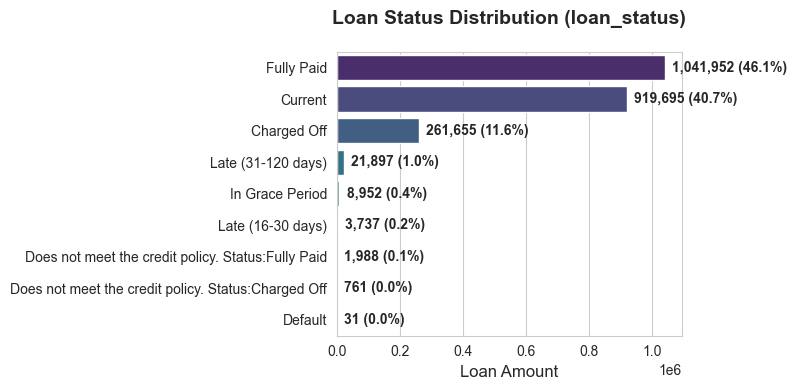

In [63]:
# Hitung distribusi
status_counts = df['loan_status'].value_counts()

# Setup style
sns.set_style("whitegrid")
plt.figure(figsize=(8, 4))

# Buat bar plot horizontal
ax = sns.barplot(
    x=status_counts.values, 
    y=status_counts.index, 
    palette="viridis"
)

# Tambahkan label nilai dan persentase
total = len(df)
for i, (count, label) in enumerate(zip(status_counts.values, status_counts.index)):
    percentage = (count / total) * 100
    ax.text(
        count + total * 0.01, 
        i, 
        f'{count:,} ({percentage:.1f}%)', 
        va='center', 
        fontsize=10, 
        fontweight='bold'
    )

# Judul dan label
plt.title('Loan Status Distribution (loan_status)', fontsize=14, fontweight='bold', pad=20)
plt.xlabel('Loan Amount', fontsize=12)
plt.ylabel('')
plt.tight_layout()
plt.show()

#### Filtering Loan Status

In [64]:
statuses = [
    'Fully Paid', 'Does not meet the credit policy. Status:Fully Paid',
    'Charged Off', 'Default', 'Does not meet the credit policy. Status:Charged Off'
]
df = df.loc[df['loan_status'].isin(statuses)].copy()

#### Zero Variance Columns

In [65]:
%%time
unique_value_df = count_unique_values(df)
columns_to_drop = unique_value_df.loc[unique_value_df['Unique_Value_Count'] <= 1]['Column_Name'].tolist()
df = df.drop(columns=columns_to_drop)

CPU times: total: 1.7 s
Wall time: 1.74 s


#### Feature Engineering

In [66]:
%%time
df['issue_d_date'] = pd.to_datetime(df['issue_d'], format='%b-%Y')
years_diff = (pd.to_datetime('2019-02-01', yearfirst='True').year - df['issue_d_date'].dt.year)
months_diff = (pd.to_datetime('2019-02-01', yearfirst='True').month - df['issue_d_date'].dt.month)
df['credit_duration'] = years_diff * 12 + months_diff
df['credit_duration'] = df['credit_duration'].astype(int)

df['earliest_cr_line_date'] = pd.to_datetime(df['earliest_cr_line'], format='%b-%Y')
years_diff_earliest = (pd.to_datetime('2019-02-01', yearfirst='True').year - df['earliest_cr_line_date'].dt.year.fillna(0))
months_diff_earliest = (pd.to_datetime('2019-02-01', yearfirst='True').month - df['earliest_cr_line_date'].dt.month.fillna(0))
df['earliest_credit_duration'] = years_diff_earliest * 12 + months_diff_earliest
df['earliest_credit_duration'] = df['earliest_credit_duration'].astype(int)

att_drop = ['issue_d','issue_d_date','earliest_cr_line','earliest_cr_line_date']
df = df.drop(columns=att_drop)

CPU times: total: 359 ms
Wall time: 361 ms


#### Eliminate features with dominant missing values (> 50%).

In [67]:
%%time
nan_info = cek_null(df)
columns_to_drop_nan = nan_info[nan_info['NaN_Proportion'] > 50].index.tolist()
df = df.drop(columns=columns_to_drop_nan)

CPU times: total: 312 ms
Wall time: 311 ms


#### Eliminate high‑cardinality categorical features & textual information.

In [68]:
%%time
att_drop = ['emp_title', 'title', 'zip_code', 'addr_state']
df = df.drop(columns=att_drop, errors='ignore')

CPU times: total: 0 ns
Wall time: 1 ms


#### Eliminate Data Leakage

In [69]:
att_leakage = ['out_prncp', 'out_prncp_inv', 'total_pymnt', 'total_pymnt_inv', 'total_rec_prncp', 'total_rec_int', 'total_rec_late_fee', 'recoveries', 'collection_recovery_fee', 'last_pymnt_d', 'last_pymnt_amnt', 'hardship_flag', 'debt_settlement_flag', 'last_credit_pull_d']
df = df.drop(columns=att_leakage)

### Encoding

In [70]:
%%time
non_numeric_cols = df.select_dtypes(exclude=np.number).columns
print("Non-numeric columns:")
for col in non_numeric_cols:
    print(f"- {col}")

Non-numeric columns:
- term
- grade
- sub_grade
- emp_length
- home_ownership
- verification_status
- loan_status
- purpose
- initial_list_status
- application_type
- disbursement_method
CPU times: total: 0 ns
Wall time: 0 ns


In [71]:
%%time
# Identify non‑numeric columns besides the target
non_numeric_cols = df.select_dtypes(include=['object', 'category']).columns.tolist()
if 'loan_status' in non_numeric_cols:
    non_numeric_cols.remove('loan_status')

# Label Encoding
le = LabelEncoder()
for col in non_numeric_cols:
    df[col] = le.fit_transform(df[col].astype(str))
    df[col] = pd.to_numeric(df[col])

CPU times: total: 1.42 s
Wall time: 1.48 s


In [72]:
%%time
status_map = {
    'Fully Paid':0, 'Does not meet the credit policy. Status:Fully Paid':0,
    'Charged Off':1, 'Default':1, 'Does not meet the credit policy. Status:Charged Off':1
}
df['loan_status'] = df['loan_status'].map(status_map)
df['loan_status'] = pd.to_numeric(df['loan_status'])

CPU times: total: 125 ms
Wall time: 97 ms


### Loan Status Distribution

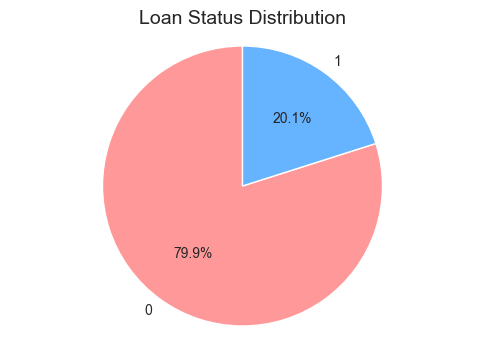

In [73]:
counts = df['loan_status'].value_counts()

# Plot
plt.figure(figsize=(6, 4))
plt.pie(counts, 
        labels=counts.index, 
        autopct='%1.1f%%',
        startangle=90,
        colors=['#ff9999','#66b3ff'])

plt.title('Loan Status Distribution', fontsize=14)
plt.axis('equal')
plt.show()

### Correlation vs Feature Importance Gain

#### Multicollinearity analysis: Identify features with high correlation.

In [74]:
%%time
# 1. Calculate correlation matrix without 'loan_status'
corr_matrix = df.drop(columns=['loan_status'], errors='ignore').corr(numeric_only=True)

# 2. Take the upper triangle of the matrix to avoid duplicates and diagonal.
upper_tri = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

# 3. Convert to a long‑format DataFrame (unpivot/stack).
high_corr_df = upper_tri.stack().reset_index()
high_corr_df.columns = ['Attribute_1', 'Attribute_2', 'Correlation']

# 4. Filter correlation values >= threshold and sort from highest to lowest.
high_corr_df = high_corr_df[high_corr_df['Correlation'] >= threshold].sort_values(by='Correlation', ascending=False)

# Menampilkan hasil
high_corr_df

CPU times: total: 6.72 s
Wall time: 6.95 s


,Attribute_1,Attribute_2,Correlation
1,loan_amnt,funded_amnt,1.00
68,funded_amnt,funded_amnt_inv,1.00
1106,open_acc,num_sats,1.00
2,loan_amnt,funded_amnt_inv,1.00
2887,num_actv_rev_tl,num_rev_tl_bal_gt_0,0.98
403,grade,sub_grade,0.98
271,int_rate,sub_grade,0.98
1775,tot_cur_bal,tot_hi_cred_lim,0.97
71,funded_amnt,installment,0.95
5,loan_amnt,installment,0.95


#### Iterative Feature Selection: Integration of Correlation and Gain Importance.

In [75]:
%%time

def iterative_feature_selection_optimized(X, y, threshold, sample_size=0.5):
    # 1. Sampling handling (supports 0 < sample_size <= 1).
    if sample_size < 1.0:
        print(f"Sampling {sample_size*100}% data for feature selection...")
        X_s, _, y_s, _ = train_test_split(X, y, train_size=sample_size, stratify=y, random_state=42)
    else:
        print("Utilize all data (100%) for feature selection....")
        X_s, y_s = X.copy(), y.copy()
    
    # 2. Calculate Gain only once at the start.
    print("Calculate Initial Feature Importance (Gain)...")
    param = param_lgbm | {'is_unbalance': True}
    full_model = LGBMClassifier(**param)
    full_model.fit(X_s, y_s)
    initial_gains = pd.Series(full_model.feature_importances_, index=X_s.columns)
    
    # 3. Calculate Correlation
    corr_matrix = X_s.corr().abs()
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
    
    high_corr_pairs = []
    for col in upper.columns:
        for idx in upper.index:
            if upper.loc[idx, col] > threshold:
                high_corr_pairs.append((idx, col))
    
    dropped_features = set()
    print(f"Analyzing {len(high_corr_pairs)} high correlation pairs....\n")

    # 4. Seleksi Berdasarkan Gain
    for feat_a, feat_b in high_corr_pairs:
        if feat_a in dropped_features or feat_b in dropped_features:
            continue
            
        gain_a = initial_gains.get(feat_a, 0)
        gain_b = initial_gains.get(feat_b, 0)
        
        # Drop items with lower gain.
        final_drop = feat_a if gain_a < gain_b else feat_b
        dropped_features.add(final_drop)
        
        print(f"Pair: ({feat_a}, {feat_b}) | Gain: {feat_a}={gain_a:.2f}, {feat_b}={gain_b:.2f}")
        print(f" > Decision: Drop {final_drop}\n")

    final_list = list(dropped_features)
    return X.drop(columns=final_list), final_list

# Execution
X = df.drop('loan_status', axis=1)
y = df['loan_status']

X_final, dropped_list = iterative_feature_selection_optimized(X, y, threshold=threshold, sample_size=0.5)

Sampling 50.0% data for feature selection...
Calculate Initial Feature Importance (Gain)...
Analyzing 13 high correlation pairs....

Pair: (loan_amnt, funded_amnt) | Gain: loan_amnt=13251.99, funded_amnt=3934.38
 > Decision: Drop funded_amnt

Pair: (loan_amnt, funded_amnt_inv) | Gain: loan_amnt=13251.99, funded_amnt_inv=6871.19
 > Decision: Drop funded_amnt_inv

Pair: (loan_amnt, installment) | Gain: loan_amnt=13251.99, installment=10620.45
 > Decision: Drop installment

Pair: (int_rate, grade) | Gain: int_rate=9795.34, grade=265514.98
 > Decision: Drop int_rate

Pair: (grade, sub_grade) | Gain: grade=265514.98, sub_grade=322743.55
 > Decision: Drop grade

Pair: (num_actv_rev_tl, num_rev_tl_bal_gt_0) | Gain: num_actv_rev_tl=12763.50, num_rev_tl_bal_gt_0=3995.12
 > Decision: Drop num_rev_tl_bal_gt_0

Pair: (open_acc, num_sats) | Gain: open_acc=176.86, num_sats=166.98
 > Decision: Drop num_sats

Pair: (tot_cur_bal, tot_hi_cred_lim) | Gain: tot_cur_bal=1403.23, tot_hi_cred_lim=7406.79
 > 

In [76]:
dropped_list

['funded_amnt',
 'grade',
 'funded_amnt_inv',
 'num_sats',
 'earliest_credit_duration',
 'tot_cur_bal',
 'num_rev_tl_bal_gt_0',
 'installment',
 'int_rate']

In [77]:
df = df.drop(columns=dropped_list)

### Drop Null Value

In [78]:
cek_null(df).loc[cek_null(df)['NaN_Proportion'] > 0]

,NaN_Count,NaN_Proportion
mths_since_recent_inq,172301,13.19
num_tl_120dpd_2m,118320,9.06
mo_sin_old_il_acct,107044,8.19
pct_tl_nvr_dlq,70430,5.39
avg_cur_bal,70297,5.38
mo_sin_rcnt_rev_tl_op,70277,5.38
num_rev_accts,70277,5.38
mo_sin_old_rev_tl_op,70277,5.38
total_rev_hi_lim,70276,5.38
tot_coll_amt,70276,5.38


In [79]:
df_null = cek_null(df)
att_null = df_null.loc[df_null['NaN_Proportion'] > 0].index.to_list()
df = df.dropna(subset=att_null)

In [80]:
df['loan_status'].value_counts()

loan_status
0    817670
1    211349
Name: count, dtype: int64

In [81]:
df.shape

(1029019, 58)

## Split

In [82]:
%%time

X = df.drop(columns=['loan_status'])
y = df['loan_status']

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)


scaler = StandardScaler()
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns, index=X_train.index)
X_val_scaled = pd.DataFrame(scaler.transform(X_val), columns=X_val.columns, index=X_val.index)

CPU times: total: 1.2 s
Wall time: 1.25 s


## RFECV

In [83]:
%%time
# 0. Determine the data fraction (0.1 = 10%, 1.0 = 100%)
sample_frac = 0.5

# 1. Data Selection Logic
if sample_frac < 1.0:
    X_proc = X_train_scaled.sample(frac=sample_frac, random_state=42)
    y_proc = y_train.loc[X_proc.index]
else:
    X_proc = X_train_scaled
    y_proc = y_train

# 2. Model Initialization & CV
param = param_lgbm | {"is_unbalance": True}
model = LGBMClassifier(**param)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# 3. RFECV Configuration
selector = RFECV(
    estimator=model,
    step=1, 
    cv=cv,
    scoring='average_precision',
    n_jobs=-1,
    verbose=1
)

# 4. Run selection on the chosen data
selector.fit(X_proc, y_proc)

# 5. Best Feature Result
selected_features = X_train.columns[selector.support_].tolist()
print(f"Menggunakan {sample_frac*100}% data")
print(f"Jumlah fitur optimal: {selector.n_features_}")
print(f"Fitur terpilih: {selected_features}")

Fitting estimator with 57 features.
Fitting estimator with 56 features.
Fitting estimator with 55 features.
Fitting estimator with 54 features.
Fitting estimator with 53 features.
Fitting estimator with 52 features.
Fitting estimator with 51 features.
Fitting estimator with 50 features.
Fitting estimator with 49 features.
Fitting estimator with 48 features.
Menggunakan 50.0% data
Jumlah fitur optimal: 47
Fitur terpilih: ['loan_amnt', 'term', 'sub_grade', 'emp_length', 'home_ownership', 'annual_inc', 'verification_status', 'purpose', 'dti', 'delinq_2yrs', 'inq_last_6mths', 'open_acc', 'pub_rec', 'revol_bal', 'revol_util', 'total_acc', 'application_type', 'tot_coll_amt', 'total_rev_hi_lim', 'acc_open_past_24mths', 'avg_cur_bal', 'bc_open_to_buy', 'bc_util', 'mo_sin_old_il_acct', 'mo_sin_old_rev_tl_op', 'mo_sin_rcnt_rev_tl_op', 'mo_sin_rcnt_tl', 'mort_acc', 'mths_since_recent_bc', 'mths_since_recent_inq', 'num_accts_ever_120_pd', 'num_actv_bc_tl', 'num_actv_rev_tl', 'num_bc_sats', 'num_bc

In [95]:
# 1. Retrieve feature importance scores from the internal RFECV model
importances = selector.estimator_.feature_importances_

# 2. Match with the selected feature names
feature_scores = pd.DataFrame({
    'Feature': selected_features,
    'Importance_Score': importances
}).sort_values(by='Importance_Score', ascending=False)

feature_scores.head(15)

,Feature,Importance_Score
2,sub_grade,"379,459.95"
46,credit_duration,"54,695.85"
1,term,"30,976.22"
0,loan_amnt,"23,580.07"
8,dti,"19,951.07"
20,avg_cur_bal,"17,155.03"
3,emp_length,"11,252.87"
19,acc_open_past_24mths,"11,156.66"
5,annual_inc,"10,470.31"
4,home_ownership,"10,438.95"


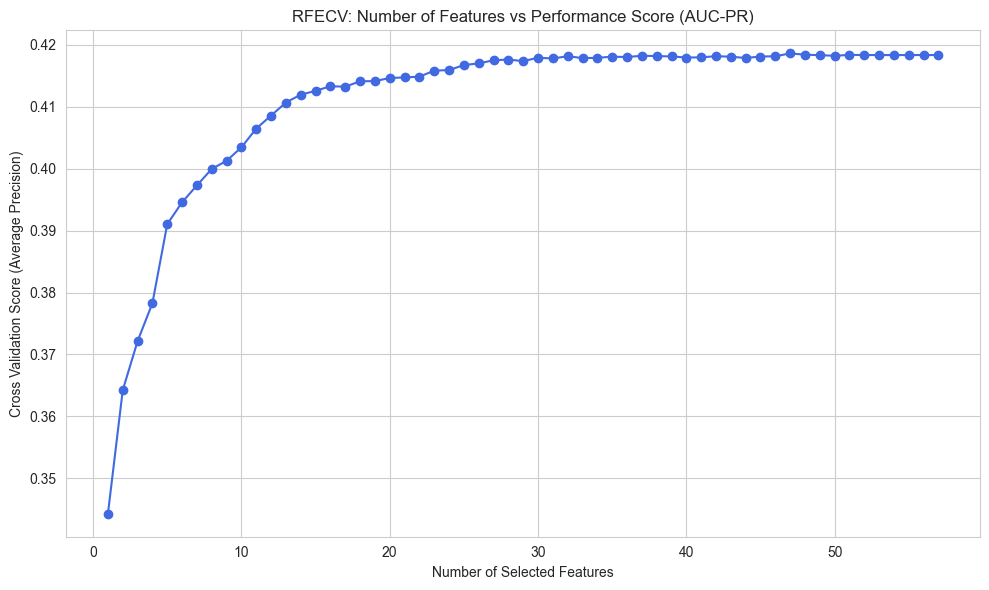

In [85]:
# Plotting RFECV results
plt.figure(figsize=(10, 6))
plt.title('RFECV: Number of Features vs Performance Score (AUC-PR)')
plt.xlabel('Number of Selected Features')
plt.ylabel('Cross Validation Score (Average Precision)')

# Getting scores from the selector
plt.plot(range(1, len(selector.cv_results_['mean_test_score']) + 1), 
         selector.cv_results_['mean_test_score'], 
         marker='o', color='royalblue')

plt.grid(True)
plt.tight_layout()
plt.savefig('rfecv_performance_plot.png')

Jumlah Fitur Optimal (Titik Siku): 13


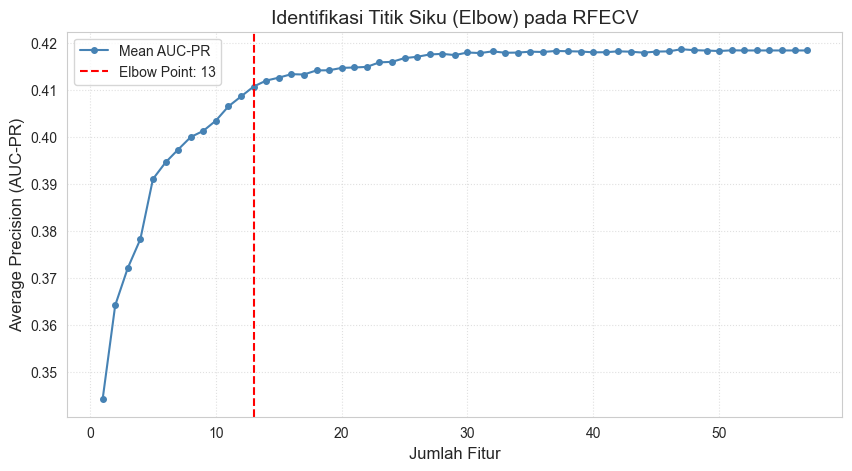

In [86]:

# 1. Extract the average score from the RFECV results
# cv_results_['mean_test_score'] stores the performance for each feature count
scores = selector.cv_results_['mean_test_score']
num_features = range(1, len(scores) + 1)

# 2. Use KneeLocator to locate the point where the curve begins to flatten
# A 'concave' curve with 'increasing' direction fits accuracy/AUC‑PR curves
kn = KneeLocator(num_features, scores, curve='concave', direction='increasing')
elbow_point = kn.knee

print(f"Jumlah Fitur Optimal (Titik Siku): {elbow_point}")

# 3. Visualize for validation
plt.figure(figsize=(10, 5))
plt.plot(num_features, scores, color='steelblue', marker='o', markersize=4, label='Mean AUC-PR')
plt.axvline(x=elbow_point, color='red', linestyle='--', label=f'Elbow Point: {elbow_point}')

plt.title('Identifikasi Titik Siku (Elbow) pada RFECV', fontsize=14)
plt.xlabel('Jumlah Fitur', fontsize=12)
plt.ylabel('Average Precision (AUC-PR)', fontsize=12)
plt.legend()
plt.grid(True, linestyle=':', alpha=0.6)
plt.show()

Varians PC1: 0.1383 (13.83%)
Varians PC2: 0.0749 (7.49%)
Total Informasi yang Terjaga: 0.2132 (21.32%)


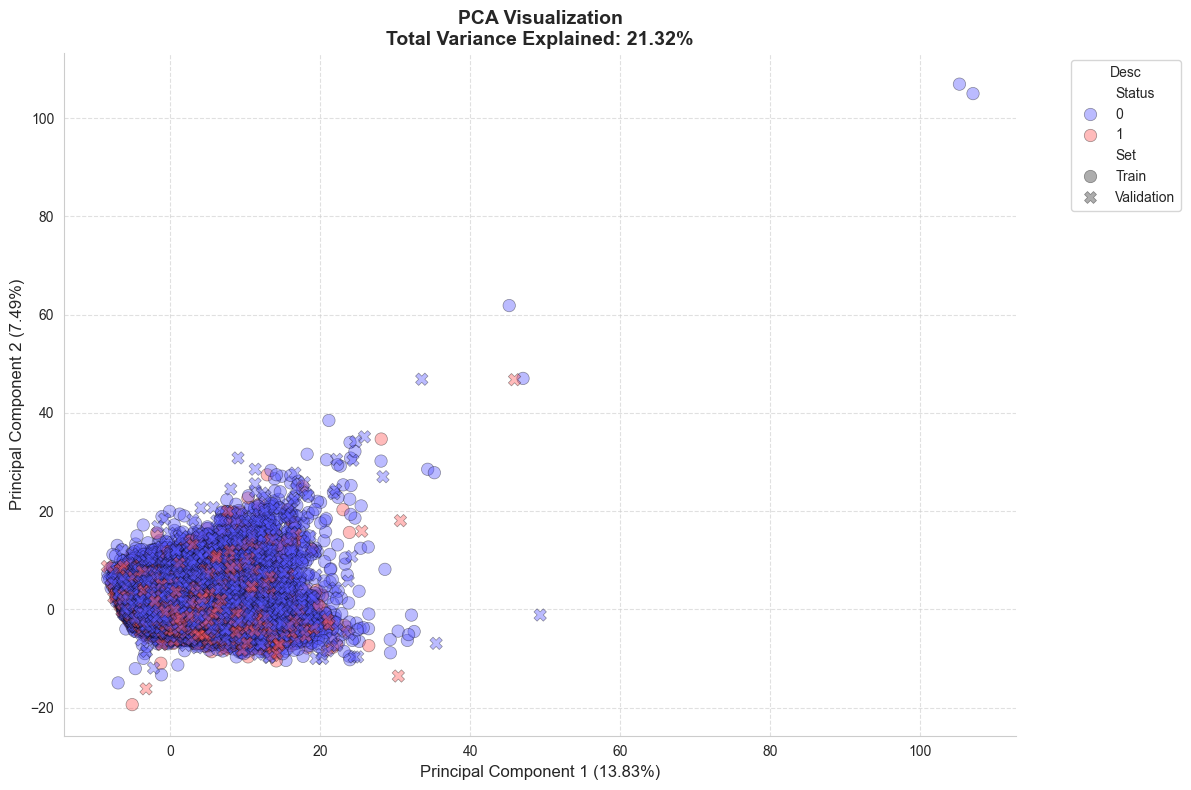

CPU times: total: 13.7 s
Wall time: 13.6 s


In [94]:
%%time
# 1. Initializing PCA for 2 Main Components
pca = PCA(n_components=2)

# 2. Fit on training data and transform
X_train_pca = pca.fit_transform(X_train_scaled.values)
X_val_pca = pca.transform(X_val_scaled.values)

# 3. Explained Variance Ratio Check
varians_pc1 = pca.explained_variance_ratio_[0]
varians_pc2 = pca.explained_variance_ratio_[1]
total_varians = varians_pc1 + varians_pc2

print(f"Varians PC1: {varians_pc1:.4f} ({varians_pc1*100:.2f}%)")
print(f"Varians PC2: {varians_pc2:.4f} ({varians_pc2*100:.2f}%)")
print(f"Total Informasi yang Terjaga: {total_varians:.4f} ({total_varians*100:.2f}%)")

# 4. Create a PCA result DataFrame to facilitate plotting
df_pca_train = pd.DataFrame(X_train_pca, columns=['PC1', 'PC2'])
df_pca_train['Status'] = y_train.values
df_pca_train['Set'] = 'Train'

df_pca_val = pd.DataFrame(X_val_pca, columns=['PC1', 'PC2'])
df_pca_val['Status'] = y_val.values
df_pca_val['Set'] = 'Validation'

df_pca_combined = pd.concat([df_pca_train, df_pca_val], ignore_index=True)

# 5. Visualization
plt.figure(figsize=(12, 8))

sns.scatterplot(
    # data=df_pca_combined.sample(300000, random_state=42),
    data=df_pca_combined,
    x='PC1', 
    y='PC2', 
    hue='Status', 
    style='Set',
    palette='seismic',
    alpha=0.4,
    s=80,
    edgecolor='k',
    linewidth=0.5
)

plt.title(f'PCA Visualization\nTotal Variance Explained: {total_varians*100:.2f}%', fontsize=14, fontweight='bold')
plt.xlabel(f'Principal Component 1 ({varians_pc1*100:.2f}%)', fontsize=12)
plt.ylabel(f'Principal Component 2 ({varians_pc2*100:.2f}%)', fontsize=12)
plt.legend(title='Desc', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, linestyle='--', alpha=0.6)
sns.despine()
plt.tight_layout()
plt.show()

## Modelling

### Scenario A

#### LightGBM

In [ ]:
%%time

# 1. Definisi Custom Scorers untuk Confusion Matrix
def get_tn(y_true, y_pred): return confusion_matrix(y_true, y_pred).ravel()[0]
def get_fp(y_true, y_pred): return confusion_matrix(y_true, y_pred).ravel()[1]
def get_fn(y_true, y_pred): return confusion_matrix(y_true, y_pred).ravel()[2]
def get_tp(y_true, y_pred): return confusion_matrix(y_true, y_pred).ravel()[3]

cv_scoring = {
    'tp': make_scorer(get_tp),
    'tn': make_scorer(get_tn),
    'fp': make_scorer(get_fp),
    'fn': make_scorer(get_fn),
    'f1': 'f1',
    'precision': 'precision',
    'recall': 'recall',
    'average_precision': 'average_precision',
    'roc_auc': 'roc_auc'
}

# 2. Filter Fitur Hasil RFECV
X_train_a = X_train_scaled[selected_features]
X_val_a = X_val_scaled[selected_features]

# 3. Inisialisasi Model LightGBM Skenario A
param = param_lgbm | {"is_unbalance": True}
model_lgbm_a = LGBMClassifier(**param)

# 4. Pelaksanaan Stratified K-Fold Cross Validation
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

print("Menjalankan Cross-Validation (5-Fold)...")
cv_results = cross_validate(
    model_lgbm_a, 
    X_train_a, 
    y_train, 
    cv=skf, 
    scoring=cv_scoring, 
    n_jobs=-1
)

# 5. Pelatihan pada Seluruh Data Training
model_lgbm_a.fit(X_train_a, y_train)

# 6. Pengujian pada Data Validasi
y_pred = model_lgbm_a.predict(X_val_a)
y_proba = model_lgbm_a.predict_proba(X_val_a)[:, 1]
tn_val, fp_val, fn_val, tp_val = confusion_matrix(y_val, y_pred).ravel()

# --- Output Evaluasi ---
print("\n" + "="*30)
print("HASIL EVALUASI SKENARIO A: LIGHTGBM")
print("="*30)

# Skor Confusion Matrix per Fold CV
print("Hasil Per Fold (TP, TN, FP, FN):")
for i in range(5):
    print(f"Fold {i+1}: TP={cv_results['test_tp'][i]}, TN={cv_results['test_tn'][i]}, FP={cv_results['test_fp'][i]}, FN={cv_results['test_fn'][i]}")

# Rata-rata Skor Cross Validation
print(f"\nCV Avg TP: {cv_results['test_tp'].mean():.0f} | TN: {cv_results['test_tn'].mean():.0f}")
print(f"CV Avg FP: {cv_results['test_fp'].mean():.0f} | FN: {cv_results['test_fn'].mean():.0f}")
print(f"CV F1-Score         : {cv_results['test_f1'].mean():.4f} (+/- {cv_results['test_f1'].std():.4f})")
print(f"CV AUC-PR (Avg Prec): {cv_results['test_average_precision'].mean():.4f}")
print(f"CV ROC-AUC          : {cv_results['test_roc_auc'].mean():.4f}")

print("\nValidation Data Metrics:")
print(f"TP: {tp_val}, TN: {tn_val}, FP: {fp_val}, FN: {fn_val}")
auc_pr = average_precision_score(y_val, y_proba)
print(f"Final AUC-PR on Validation: {auc_pr:.4f}")

print("\nDetail Laporan Klasifikasi (Data Validasi):")
print(classification_report(y_val, y_pred))

Menjalankan Cross-Validation (5-Fold)...

HASIL EVALUASI SKENARIO A: LIGHTGBM
Hasil Per Fold (TP, TN, FP, FN):
Fold 1: TP=10159, TN=118059, FP=12769, FN=23656
Fold 2: TP=10245, TN=118170, FP=12657, FN=23571
Fold 3: TP=10230, TN=117651, FP=13176, FN=23586
Fold 4: TP=10248, TN=118127, FP=12700, FN=23568
Fold 5: TP=10233, TN=118089, FP=12738, FN=23583

CV Avg TP: 10223 | TN: 118019
CV Avg FP: 12808 | FN: 23593
CV F1-Score         : 0.3597 (+/- 0.0016)
CV AUC-PR (Avg Prec): 0.3905
CV ROC-AUC          : 0.7170

Validation Data Metrics:
TP: 12679, TN: 147771, FP: 15763, FN: 29591
Final AUC-PR on Validation: 0.3909

Detail Laporan Klasifikasi (Data Validasi):
              precision    recall  f1-score   support

           0       0.83      0.90      0.87    163534
           1       0.45      0.30      0.36     42270

    accuracy                           0.78    205804
   macro avg       0.64      0.60      0.61    205804
weighted avg       0.75      0.78      0.76    205804

CPU times: t

#### XGBoost

In [ ]:
%%time
# 1. Definisi Custom Scorers untuk Confusion Matrix
def get_tn(y_true, y_pred): return confusion_matrix(y_true, y_pred).ravel()[0]
def get_fp(y_true, y_pred): return confusion_matrix(y_true, y_pred).ravel()[1]
def get_fn(y_true, y_pred): return confusion_matrix(y_true, y_pred).ravel()[2]
def get_tp(y_true, y_pred): return confusion_matrix(y_true, y_pred).ravel()[3]

cv_scoring = {
    'tp': make_scorer(get_tp),
    'tn': make_scorer(get_tn),
    'fp': make_scorer(get_fp),
    'fn': make_scorer(get_fn),
    'f1': 'f1',
    'precision': 'precision',
    'recall': 'recall',
    'average_precision': 'average_precision',
    'roc_auc': 'roc_auc'
}

# 2. Filter Fitur Hasil RFECV
X_train_xgb = X_train_scaled[selected_features]
X_val_xgb = X_val_scaled[selected_features]

# 3. Hitung Rasio untuk Penanganan Imbalance
# Formula: sum(negative) / sum(positive)
ratio = float(y_train.value_counts()[0] / y_train.value_counts()[1])

# 4. Inisialisasi Model XGBoost
param = param_xgb | {"scale_pos_weight":ratio}
model_xgb_a = XGBClassifier(**param)

# 5. Stratified K-Fold Cross Validation
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

print("Menjalankan Cross-Validation XGBoost (5-Fold)...")
cv_results_xgb = cross_validate(
    model_xgb_a, 
    X_train_xgb, 
    y_train, 
    cv=skf, 
    scoring=cv_scoring, 
    n_jobs=-1
)

# 6. Training dan Prediksi
model_xgb_a.fit(X_train_xgb, y_train)
y_pred_xgb = model_xgb_a.predict(X_val_xgb)
y_proba_xgb = model_xgb_a.predict_proba(X_val_xgb)[:, 1]
tn_val, fp_val, fn_val, tp_val = confusion_matrix(y_val, y_pred_xgb).ravel()

# --- Output Evaluasi ---
print("\n" + "="*30)
print("HASIL EVALUASI SKENARIO A: XGBOOST")
print("="*30)

# Skor Confusion Matrix per Fold CV
print("Hasil Per Fold (TP, TN, FP, FN):")
for i in range(5):
    print(f"Fold {i+1}: TP={cv_results_xgb['test_tp'][i]}, TN={cv_results_xgb['test_tn'][i]}, FP={cv_results_xgb['test_fp'][i]}, FN={cv_results_xgb['test_fn'][i]}")

# Rata-rata Skor Cross Validation
print(f"\nCV Avg TP: {cv_results_xgb['test_tp'].mean():.0f} | TN: {cv_results_xgb['test_tn'].mean():.0f}")
print(f"CV Avg FP: {cv_results_xgb['test_fp'].mean():.0f} | FN: {cv_results_xgb['test_fn'].mean():.0f}")
print(f"CV F1-Score         : {cv_results_xgb['test_f1'].mean():.4f} (+/- {cv_results_xgb['test_f1'].std():.4f})")
print(f"CV AUC-PR (Avg Prec): {cv_results_xgb['test_average_precision'].mean():.4f}")
print(f"CV ROC-AUC          : {cv_results_xgb['test_roc_auc'].mean():.4f}")

print("\nValidation Data Metrics:")
print(f"TP: {tp_val}, TN: {tn_val}, FP: {fp_val}, FN: {fn_val}")
auc_pr_xgb = average_precision_score(y_val, y_proba_xgb)
print(f"Final AUC-PR on Validation: {auc_pr_xgb:.4f}")

print("\nDetail Laporan Klasifikasi (Data Validasi):")
print(classification_report(y_val, y_pred_xgb))

Menjalankan Cross-Validation XGBoost (5-Fold)...

HASIL EVALUASI SKENARIO A: XGBOOST
Hasil Per Fold (TP, TN, FP, FN):
Fold 1: TP=23247, TN=82296, FP=48532, FN=10568
Fold 2: TP=23234, TN=82486, FP=48341, FN=10582
Fold 3: TP=23132, TN=82344, FP=48483, FN=10684
Fold 4: TP=23363, TN=81965, FP=48862, FN=10453
Fold 5: TP=23203, TN=82765, FP=48062, FN=10613

CV Avg TP: 23236 | TN: 82371
CV Avg FP: 48456 | FN: 10580
CV F1-Score         : 0.4405 (+/- 0.0009)
CV AUC-PR (Avg Prec): 0.3912
CV ROC-AUC          : 0.7175

Validation Data Metrics:
TP: 28968, TN: 102600, FP: 60934, FN: 13302
Final AUC-PR on Validation: 0.3917

Detail Laporan Klasifikasi (Data Validasi):
              precision    recall  f1-score   support

           0       0.89      0.63      0.73    163534
           1       0.32      0.69      0.44     42270

    accuracy                           0.64    205804
   macro avg       0.60      0.66      0.59    205804
weighted avg       0.77      0.64      0.67    205804

CPU times: 

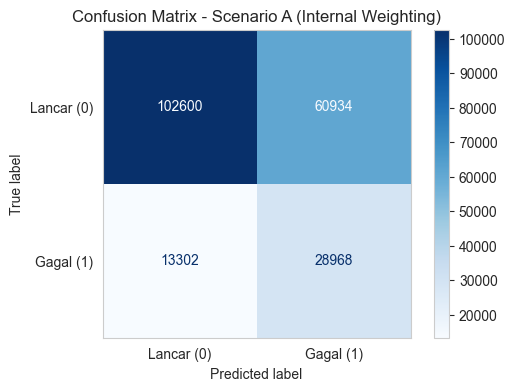

TP: 28968 FN: 13302 FP: 60934 TN: 102600


In [ ]:
# 1. Hitung Matrix
cm_a = confusion_matrix(y_val, y_pred_xgb)

# 2. Visualisasi
fig, ax = plt.subplots(figsize=(6, 4))
disp_a = ConfusionMatrixDisplay(confusion_matrix=cm_a, display_labels=['Lancar (0)', 'Gagal (1)'])
disp_a.plot(cmap='Blues', ax=ax, values_format='d')

plt.title('Confusion Matrix - Scenario A (Internal Weighting)')
plt.grid(False)
plt.show()

# Interpretasi Singkat
tn, fp, fn, tp = cm_a.ravel()
print(f"TP: {tp}", f"FN: {fn}", f"FP: {fp}", f"TN: {tn}")

### Scenario B

#### LightGBM

In [ ]:
%%time

# 1. Definisi Custom Scorers untuk Confusion Matrix
def get_tn(y_true, y_pred): return confusion_matrix(y_true, y_pred).ravel()[0]
def get_fp(y_true, y_pred): return confusion_matrix(y_true, y_pred).ravel()[1]
def get_fn(y_true, y_pred): return confusion_matrix(y_true, y_pred).ravel()[2]
def get_tp(y_true, y_pred): return confusion_matrix(y_true, y_pred).ravel()[3]

cv_scoring = {
    'tp': make_scorer(get_tp),
    'tn': make_scorer(get_tn),
    'fp': make_scorer(get_fp),
    'fn': make_scorer(get_fn),
    'f1': 'f1',
    'precision': 'precision',
    'recall': 'recall',
    'average_precision': 'average_precision',
    'roc_auc': 'roc_auc'
}

# 2. Data Preparation
X_train_b = X_train_scaled[selected_features]
X_val_b = X_val_scaled[selected_features]

# 3. ADASYN & Model Setup
nn_params = NearestNeighbors(n_neighbors=5, n_jobs=-1)
adasyn = ADASYN(random_state=42, n_neighbors=nn_params, sampling_strategy='auto')
# is_unbalance=False karena sudah diseimbangkan oleh ADASYN
model_lgbm_b = LGBMClassifier(**(param_lgbm | {"is_unbalance": False}))

# 4. Cross-Validation with Pipeline (Mencegah Data Leakage)
pipeline_lgbm = ImbPipeline([('resample', adasyn), ('classifier', model_lgbm_b)])
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

print("Running Cross-Validation Scenario B (LGBM + ADASYN)...")
cv_results_b = cross_validate(
    pipeline_lgbm, 
    X_train_b, 
    y_train, 
    cv=skf, 
    scoring=cv_scoring, 
    n_jobs=-1
)

# 5. Final Training & Testing
# Resampling pada seluruh data train untuk model final
X_train_res, y_train_res = adasyn.fit_resample(X_train_b, y_train)

print("Final Model Training Scenario B...")
model_lgbm_b.fit(X_train_res, y_train_res)

y_pred_b = model_lgbm_b.predict(X_val_b)
y_proba_b = model_lgbm_b.predict_proba(X_val_b)[:, 1]
tn_val, fp_val, fn_val, tp_val = confusion_matrix(y_val, y_pred_b).ravel()

# --- Output Evaluasi ---
title = "EVALUATION RESULTS SCENARIO B: LGBM + ADASYN"
print("\n" + "="*len(title))
print(title)
print("="*len(title))

# Skor Confusion Matrix per Fold CV
print("Hasil Per Fold (TP, TN, FP, FN):")
for i in range(5):
    print(f"Fold {i+1}: TP={cv_results_b['test_tp'][i]}, TN={cv_results_b['test_tn'][i]}, FP={cv_results_b['test_fp'][i]}, FN={cv_results_b['test_fn'][i]}")

# Rata-rata Skor Cross Validation
print(f"\nCV Avg TP: {cv_results_b['test_tp'].mean():.0f} | TN: {cv_results_b['test_tn'].mean():.0f}")
print(f"CV Avg FP: {cv_results_b['test_fp'].mean():.0f} | FN: {cv_results_b['test_fn'].mean():.0f}")
print(f"CV F1-Score         : {cv_results_b['test_f1'].mean():.4f} (+/- {cv_results_b['test_f1'].std():.4f})")
print(f"CV AUC-PR (Avg Prec): {cv_results_b['test_average_precision'].mean():.4f}")
print(f"CV ROC-AUC          : {cv_results_b['test_roc_auc'].mean():.4f}")

print("\nValidation Data Metrics:")
print(f"TP: {tp_val}, TN: {tn_val}, FP: {fp_val}, FN: {fn_val}")
final_auc_pr = average_precision_score(y_val, y_proba_b)
print(f"Final AUC-PR on Validation: {final_auc_pr:.4f}")

print("\nDetail Laporan Klasifikasi (Data Validasi):")
print(classification_report(y_val, y_pred_b))

Running Cross-Validation Scenario B (LGBM + ADASYN)...
Final Model Training Scenario B...

EVALUATION RESULTS SCENARIO B: LGBM + ADASYN
Hasil Per Fold (TP, TN, FP, FN):
Fold 1: TP=8840, TN=117942, FP=12886, FN=24975
Fold 2: TP=8511, TN=118223, FP=12604, FN=25305
Fold 3: TP=8494, TN=118031, FP=12796, FN=25322
Fold 4: TP=8546, TN=118185, FP=12642, FN=25270
Fold 5: TP=8673, TN=118327, FP=12500, FN=25143

CV Avg TP: 8613 | TN: 118142
CV Avg FP: 12686 | FN: 25203
CV F1-Score         : 0.3125 (+/- 0.0038)
CV AUC-PR (Avg Prec): 0.3603
CV ROC-AUC          : 0.6959

Validation Data Metrics:
TP: 10454, TN: 148041, FP: 15493, FN: 31816
Final AUC-PR on Validation: 0.3576

Detail Laporan Klasifikasi (Data Validasi):
              precision    recall  f1-score   support

           0       0.82      0.91      0.86    163534
           1       0.40      0.25      0.31     42270

    accuracy                           0.77    205804
   macro avg       0.61      0.58      0.58    205804
weighted avg   

#### XGBoost

In [ ]:
%%time

# 1. Definisi Custom Scorers untuk Confusion Matrix
def get_tn(y_true, y_pred): return confusion_matrix(y_true, y_pred).ravel()[0]
def get_fp(y_true, y_pred): return confusion_matrix(y_true, y_pred).ravel()[1]
def get_fn(y_true, y_pred): return confusion_matrix(y_true, y_pred).ravel()[2]
def get_tp(y_true, y_pred): return confusion_matrix(y_true, y_pred).ravel()[3]

cv_scoring = {
    'tp': make_scorer(get_tp),
    'tn': make_scorer(get_tn),
    'fp': make_scorer(get_fp),
    'fn': make_scorer(get_fn),
    'f1': 'f1',
    'precision': 'precision',
    'recall': 'recall',
    'average_precision': 'average_precision',
    'roc_auc': 'roc_auc'
}

# 2. Data Preparation
X_train_xgb_b = X_train_scaled[selected_features]
X_val_xgb_b = X_val_scaled[selected_features]

# 3. ADASYN Configuration
nn_params = NearestNeighbors(n_neighbors=5, n_jobs=-1)
adasyn = ADASYN(random_state=42, n_neighbors=nn_params, sampling_strategy='auto')

# scale_pos_weight=1 karena dataset diseimbangkan oleh ADASYN secara fisik
param = param_xgb | {"scale_pos_weight": 1}

# 4. XGBoost Modeling & Pipeline
model_xgb_b = XGBClassifier(**param)
pipeline_xgb = ImbPipeline([
    ('resample', adasyn),
    ('classifier', model_xgb_b)
])

# 5. Cross-Validation (Mencegah Data Leakage)
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
print("Running Cross-Validation Scenario B (XGBoost + ADASYN)...")
cv_results_xgb_b = cross_validate(
    pipeline_xgb, 
    X_train_xgb_b, y_train, 
    cv=skf, 
    scoring=cv_scoring, 
    n_jobs=-1 
)

# 6. Final Resampling & Training
# Resampling dilakukan pada seluruh data latih untuk model final
X_train_res, y_train_res = adasyn.fit_resample(X_train_xgb_b, y_train)

print("Final Model Training Scenario B (XGBoost)...")
model_xgb_b.fit(X_train_res, y_train_res)

# 7. Testing pada Data Validasi (Unseen Data)
y_pred_xgb_b = model_xgb_b.predict(X_val_xgb_b)
y_proba_xgb_b = model_xgb_b.predict_proba(X_val_xgb_b)[:, 1]

# Ambil Confusion Matrix Data Validasi
tn_val, fp_val, fn_val, tp_val = confusion_matrix(y_val, y_pred_xgb_b).ravel()

# --- Output Evaluasi ---
title = "EVALUATION RESULTS SCENARIO B: XGBOOST + ADASYN"
print("\n" + "="*len(title))
print(title)
print("="*len(title))

# Skor Confusion Matrix per Fold CV
print("Hasil Per Fold (TP, TN, FP, FN):")
for i in range(5):
    print(f"Fold {i+1}: TP={cv_results_xgb_b['test_tp'][i]}, TN={cv_results_xgb_b['test_tn'][i]}, FP={cv_results_xgb_b['test_fp'][i]}, FN={cv_results_xgb_b['test_fn'][i]}")

# Rata-rata Skor Cross Validation
print(f"\nCV Avg TP: {cv_results_xgb_b['test_tp'].mean():.0f} | TN: {cv_results_xgb_b['test_tn'].mean():.0f}")
print(f"CV Avg FP: {cv_results_xgb_b['test_fp'].mean():.0f} | FN: {cv_results_xgb_b['test_fn'].mean():.0f}")
print(f"CV F1-Score         : {cv_results_xgb_b['test_f1'].mean():.4f} (+/- {cv_results_xgb_b['test_f1'].std():.4f})")
print(f"CV AUC-PR (Avg Prec): {cv_results_xgb_b['test_average_precision'].mean():.4f}")
print(f"CV ROC-AUC          : {cv_results_xgb_b['test_roc_auc'].mean():.4f}")

print("\nValidation Data Metrics:")
print(f"TP: {tp_val}, TN: {tn_val}, FP: {fp_val}, FN: {fn_val}")
auc_pr_xgb_b = average_precision_score(y_val, y_proba_xgb_b)
print(f"Final AUC-PR on Validation: {auc_pr_xgb_b:.4f}")

print("\nDetailed Classification Report (Validation Data):")
print(classification_report(y_val, y_pred_xgb_b))

Running Cross-Validation Scenario B (XGBoost + ADASYN)...
Final Model Training Scenario B (XGBoost)...

EVALUATION RESULTS SCENARIO B: XGBOOST + ADASYN
Hasil Per Fold (TP, TN, FP, FN):
Fold 1: TP=18026, TN=94723, FP=36105, FN=15789
Fold 2: TP=18147, TN=95982, FP=34845, FN=15669
Fold 3: TP=18470, TN=93790, FP=37037, FN=15346
Fold 4: TP=19252, TN=91436, FP=39391, FN=14564
Fold 5: TP=19358, TN=91273, FP=39554, FN=14458

CV Avg TP: 18651 | TN: 93441
CV Avg FP: 37386 | FN: 15165
CV F1-Score         : 0.4151 (+/- 0.0030)
CV AUC-PR (Avg Prec): 0.3535
CV ROC-AUC          : 0.6938

Validation Data Metrics:
TP: 22350, TN: 119510, FP: 44024, FN: 19920
Final AUC-PR on Validation: 0.3534

Detailed Classification Report (Validation Data):
              precision    recall  f1-score   support

           0       0.86      0.73      0.79    163534
           1       0.34      0.53      0.41     42270

    accuracy                           0.69    205804
   macro avg       0.60      0.63      0.60    

## Analysis

### PCA

In [ ]:
X_resampled, y_resampled = adasyn.fit_resample(X_train_scaled, y_train)

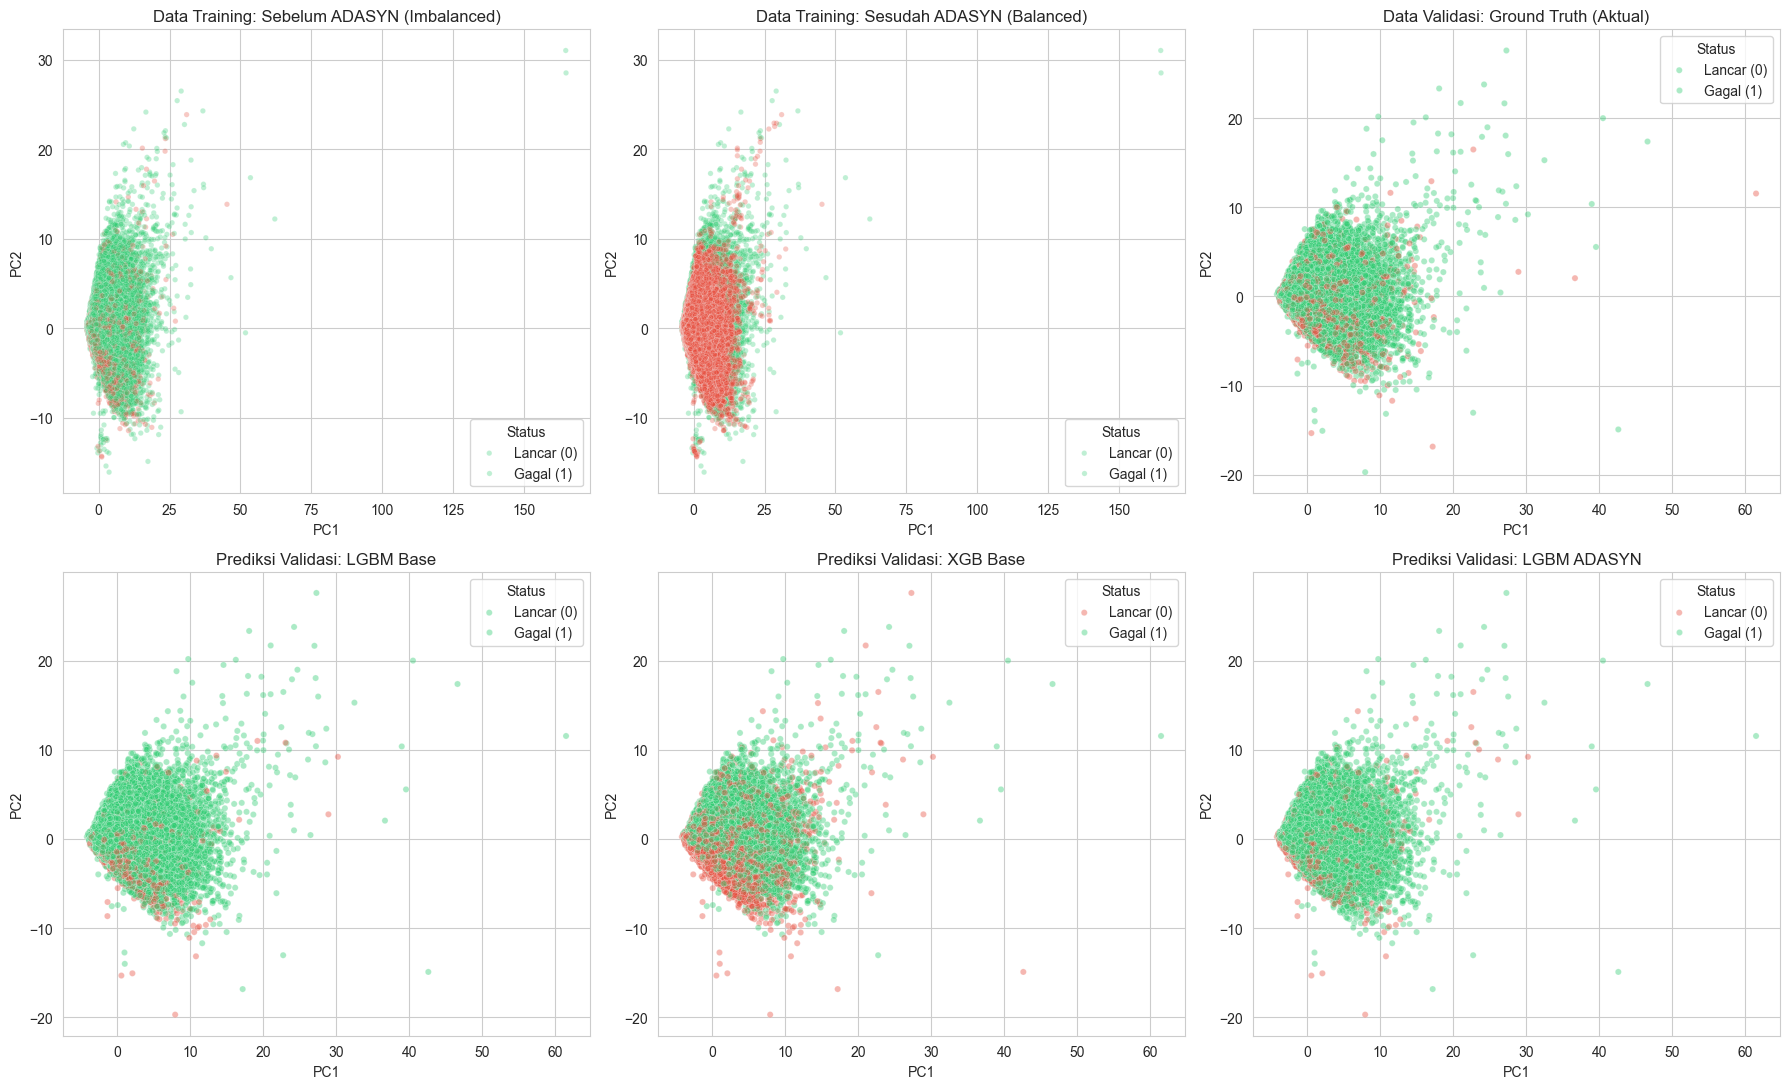

In [ ]:
def plot_comprehensive_pca(X_orig, y_orig, X_res, y_res, X_val, y_val, models_dict):
    """
    X_orig, y_orig: Training data before ADASYN
    X_res, y_res  : Training data after ADASYN
    X_val, y_val  : Original validation data
    models_dict   : {'LGBM Base': lgbm_base, 'XGB Base': xgb_base, 
                     'LGBM ADASYN': lgbm_adasyn, 'XGB ADASYN': xgb_adasyn}
    """
    # 1. PCA Initialization (Fit on original data to keep coordinates consistent)
    pca = PCA(n_components=2, random_state=42)
    pca.fit(X_orig)
    
    # Transform all datasets
    pca_orig = pca.transform(X_orig)
    pca_res = pca.transform(X_res)
    pca_val = pca.transform(X_val)
    
    # 2. Setup Plot Grid (2 Rows: Data Distribution & Model Prediction)
    fig, axes = plt.subplots(2, 3, figsize=(18, 11))
    palette = {0: '#2ecc71', 1: '#e74c3c'}
    
    # --- ROW 1: TRAINING DATA DISTRIBUTION ---
    # Before ADASYN
    sns.scatterplot(x=pca_orig[:, 0], y=pca_orig[:, 1], hue=y_orig, 
                    ax=axes[0, 0], palette=palette, alpha=0.3, s=15)
    axes[0, 0].set_title("Data Training: Sebelum ADASYN (Imbalanced)", fontsize=12)
    
    # After ADASYN
    sns.scatterplot(x=pca_res[:, 0], y=pca_res[:, 1], hue=y_res, 
                    ax=axes[0, 1], palette=palette, alpha=0.3, s=15)
    axes[0, 1].set_title("Data Training: Sesudah ADASYN (Balanced)", fontsize=12)
    
    # Ground Truth Validasi
    sns.scatterplot(x=pca_val[:, 0], y=pca_val[:, 1], hue=y_val, 
                    ax=axes[0, 2], palette=palette, alpha=0.4, s=20)
    axes[0, 2].set_title("Data Validasi: Ground Truth (Aktual)", fontsize=12)

    # --- ROW 2: MODEL PREDICTION ON VALIDATION DATA ---
    model_names = list(models_dict.keys())[:3] 
    
    for i, name in enumerate(model_names):
        y_pred = models_dict[name].predict(X_val)
        sns.scatterplot(x=pca_val[:, 0], y=pca_val[:, 1], hue=y_pred, 
                        ax=axes[1, i], palette=palette, alpha=0.4, s=20)
        axes[1, i].set_title(f"Prediksi Validasi: {name}", fontsize=12)

    for ax in axes.flat:
        ax.set_xlabel("PC1")
        ax.set_ylabel("PC2")
        ax.legend(title="Status", labels=["Lancar (0)", "Gagal (1)"])

    plt.tight_layout()
    plt.show()

models = {'LGBM Base': model_lgbm_a, 'XGB Base': model_xgb_a, 'LGBM ADASYN': model_lgbm_b, 'XGB ADASYN': model_xgb_b}
plot_comprehensive_pca(X_train_scaled[selected_features], y_train, X_resampled[selected_features], y_resampled, X_val_scaled[selected_features], y_val, models)

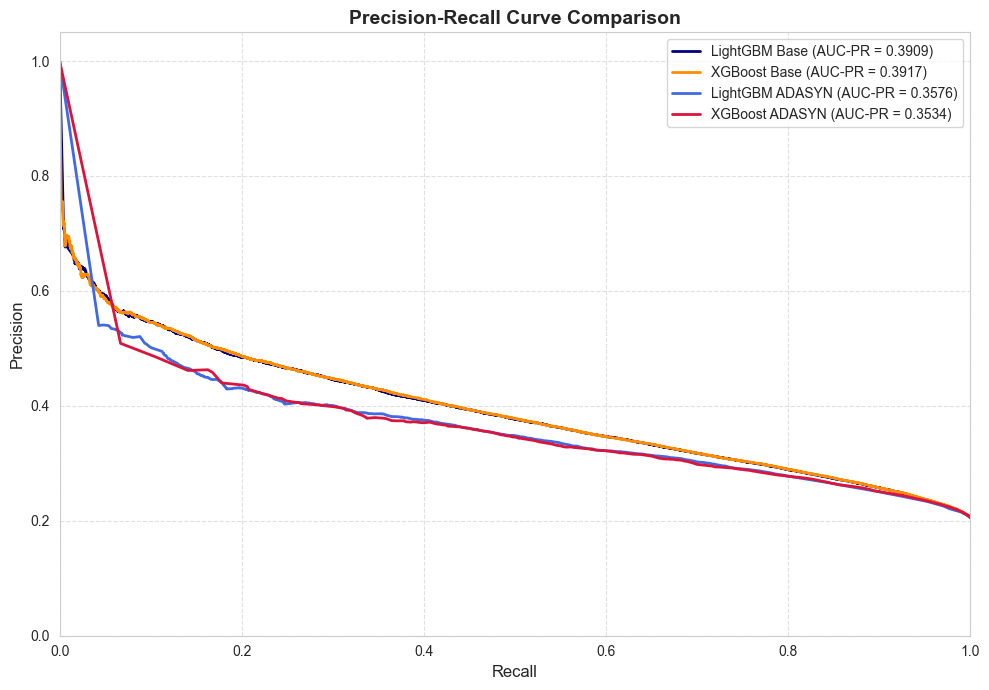

In [ ]:
from sklearn.metrics import precision_recall_curve, average_precision_score

# 1. Hitung Probabilitas untuk semua model
# Skenario A (Base)
y_proba_lgbm_a = model_lgbm_a.predict_proba(X_val_a)[:, 1]
y_proba_xgb_a = model_xgb_a.predict_proba(X_val_a)[:, 1]

# Skenario B (ADASYN)
y_proba_lgbm_b = model_lgbm_b.predict_proba(X_val_b)[:, 1]
y_proba_xgb_b = model_xgb_b.predict_proba(X_val_b)[:, 1]

# 2. List untuk plotting
models_eval = [
    ('LightGBM Base', y_proba_lgbm_a, 'navy'),
    ('XGBoost Base', y_proba_xgb_a, 'darkorange'),
    ('LightGBM ADASYN', y_proba_lgbm_b, 'royalblue'),
    ('XGBoost ADASYN', y_proba_xgb_b, 'crimson')
]

# 3. Visualisasi
plt.figure(figsize=(10, 7))

for name, proba, color in models_eval:
    precision, recall, _ = precision_recall_curve(y_val, proba)
    ap_score = average_precision_score(y_val, proba)
    plt.plot(recall, precision, color=color, lw=2, 
             label=f'{name} (AUC-PR = {ap_score:.4f})')

plt.xlabel('Recall', fontsize=12)
plt.ylabel('Precision', fontsize=12)
plt.title('Precision-Recall Curve Comparison', fontsize=14, fontweight='bold')
plt.legend(loc="upper right")
plt.grid(True, linestyle='--', alpha=0.6)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.tight_layout()
plt.show()